## Uczenie maszynowe UMZ 2019/2020
### 5 maja 2020
# 8. Uczenie nienadzorowane

Wyobraźmy sobie, że mamy następujący problem:

Mamy zbiór okazów roślin i dysponujemy pewnymi danymi na ich temat (długość płatków kwiatów, ich szerokość itp.), ale zupełnie **nie wiemy**, do jakich gatunków one należą (nie wiemy nawet, ile jest tych gatunków).

Chcemy automatycznie podzielić zbiór posiadanych okazów na nie więcej niż $k$ grup (klastrów) ($k$ ustalamy z góry), czyli dokonać **grupowania (klastrowania)** zbioru przykładów.

Jest to zagadnienie z kategorii uczenia nienadzorowanego.

W celu jego rozwiązania użyjemy algorytmu $k$ średnich.

## 8.1. Algorytm $k$ średnich

In [1]:
# Przydatne importy

import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas
import random
import seaborn

%matplotlib inline

In [16]:
# Wczytanie danych (gatunki kosaćców)

data_iris_raw = pandas.read_csv('iris.csv')
data_iris = pandas.DataFrame()
data_iris['x1'] = data_iris_raw['sl']
data_iris['x2'] = data_iris_raw['sw']
data_iris['x3'] = data_iris_raw['pl']
data_iris['x4'] = data_iris_raw['sw']

# Nie używamy w ogóle kolumny ostatniej kolumny ("Gatunek"), 
# ponieważ chcemy dokonać uczenia nienadzorowanego.
# Przyjmujemy, że w ogóle nie dysponujemy danymi na temat gatunku,
# mamy tylko 150 nieznanych roślin.

X = data_iris.values
Xs = data_iris.values[:, 2:4]

In [3]:
# Wykres danych
def plot_unlabeled_data(X, col1=0, col2=1, x1label=r'$x_1$', x2label=r'$x_2$'):    
    fig = plt.figure(figsize=(16*.7, 9*.7))
    ax = fig.add_subplot(111)
    fig.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9)
    X1 = X[:, col1].tolist()
    X2 = X[:, col2].tolist()
    ax.scatter(X1, X2, c='k', marker='o', s=50, label='Dane')
    ax.set_xlabel(x1label)
    ax.set_ylabel(x2label)
    ax.margins(.05, .05)
    return fig

In [4]:
# Przygotowanie interaktywnego wykresu

dropdown_arg1 = widgets.Dropdown(options=[0, 1, 2, 3], value=2, description='arg1')
dropdown_arg2 = widgets.Dropdown(options=[0, 1, 2, 3], value=3, description='arg2')

def interactive_unlabeled_data(arg1, arg2):
    fig = plot_unlabeled_data(
        X, col1=arg1, col2=arg2, x1label='$x_{}$'.format(arg1), x2label='$x_{}$'.format(arg2))

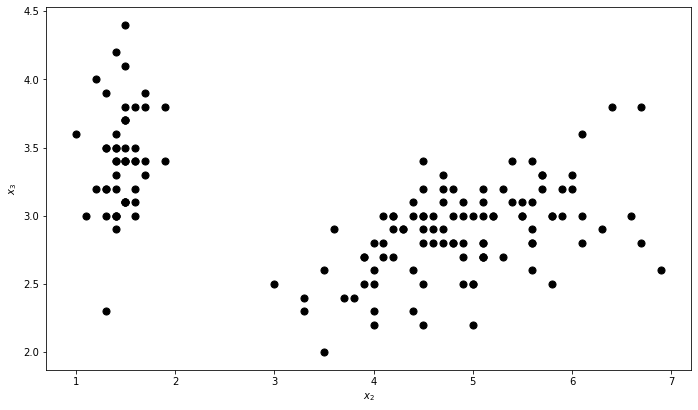

<function __main__.interactive_unlabeled_data(arg1, arg2)>

In [5]:
widgets.interact(interactive_unlabeled_data, arg1=dropdown_arg1, arg2=dropdown_arg2)

Powyższy wykres przedstawia surowe dane.
Ponieważ nasze obserwacje mają 4 współrzędne, na płaskim wykresie możemy przedstawić tylko dwie z nich.

Dlatego powyższy wykres umożliwia wybór dwóch współrzędnych, na które chcemy rzutować.

Wszystkie takie „rzuty” przedstawia również wykres poniżej.

/home/pawel/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


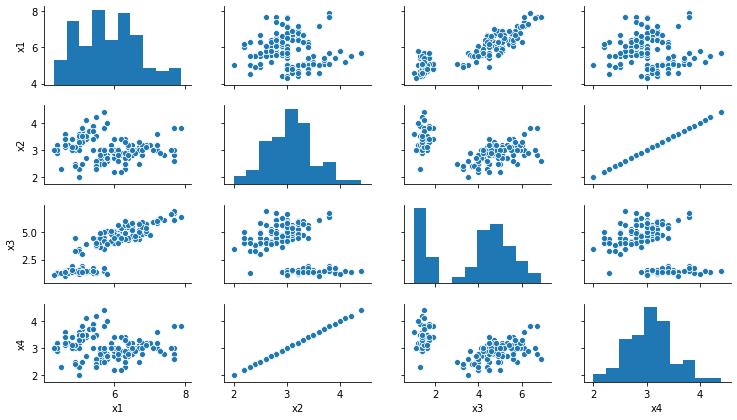

In [6]:
seaborn.pairplot(data_iris, vars=data_iris.columns, size=1.5, aspect=1.75)

In [7]:
# Odległość euklidesowa
def euclidean_distance(x1, x2):
    return np.linalg.norm(x1 - x2)

In [8]:
# Algorytm k średnich
def k_means(X, k, distance=euclidean_distance):
    history = []
    Y = []
 
    # Wylosuj centroid dla każdej klasy
    centroids = [[random.uniform(X.min(axis=0)[f], X.max(axis=0)[f])
                     for f in range(X.shape[1])]
                 for c in range(k)]

    # Powtarzaj, dopóki klasy się zmieniają
    while True:
        distances = [[distance(centroids[c], x) for c in range(k)] for x in X]
        Y_new = [d.index(min(d)) for d in distances]
        if Y_new == Y:
            break
        Y = Y_new
        XY = np.asarray(np.concatenate((X, np.matrix(Y).T), axis=1))
        Xc = [XY[XY[:, 2] == c][:, :-1] for c in range(k)]
        centroids = [[Xc[c].mean(axis=0)[f] for f in range(X.shape[1])]
                     for c in range(k)]
        history.append((centroids, Y))

    result = history[-1][1]
    return result, history

In [9]:
# Wykres danych - klastrowanie
def plot_clusters(X, Y, k, centroids=None):
    color = ['r', 'g', 'b', 'c', 'm', 'y', 'k']
    fig = plt.figure(figsize=(16*.7, 9*.7))
    ax = fig.add_subplot(111)
    fig.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9)

    X1 = X[:, 0].tolist()
    X2 = X[:, 1].tolist()
    X1 = [[x for x, y in zip(X1, Y) if y == c] for c in range(k)]
    X2 = [[x for x, y in zip(X2, Y) if y == c] for c in range(k)]

    for c in range(k):
        ax.scatter(X1[c], X2[c], c=color[c], marker='o', s=25, label='Dane')
        if centroids:
            ax.scatter([centroids[c][0]], [centroids[c][1]], c=color[c], marker='+', s=500, label='Centroid')

    ax.set_xlabel(r'$x_1$')
    ax.set_ylabel(r'$x_2$')
    ax.margins(.05, .05)
    return fig

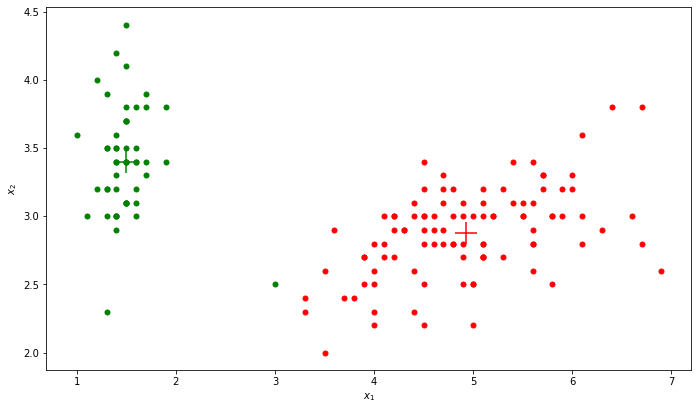

In [10]:
Ys, history = k_means(Xs, 2)
fig = plot_clusters(Xs, Ys, 2, centroids=history[-1][0]),

In [11]:
# Przygotowanie interaktywnego wykresu

slider_k = widgets.IntSlider(min=1, max=7, step=1, value=2, description=r'$k$', width=300)

def interactive_kmeans_k(steps, history, k):
    if steps >= len(history) or steps == 10:
        steps = len(history) - 1
    fig = plot_clusters(Xs, history[steps][1], k, centroids=history[steps][0])
    
def interactive_kmeans(k):
    slider_steps = widgets.IntSlider(min=1, max=10, step=1, value=1, description=r'steps', width=300)
    _, history = k_means(Xs, k)
    widgets.interact(interactive_kmeans_k, steps=slider_steps,
                     history=widgets.fixed(history), k=widgets.fixed(k))

In [12]:
widgets.interact_manual(interactive_kmeans, k=slider_k) 

interactive(children=(IntSlider(value=2, description='$k$', max=7, min=1), Button(description='Run Interact', …

<function __main__.interactive_kmeans(k)>

### Algorytm $k$ średnich – dane wejściowe

* $k$ – liczba klastrów
* zbiór uczący $X = \{ x^{(1)}, x^{(2)}, \ldots, x^{(m)} \}$, $x^{(i)} \in \mathbb{R}^n$

Na wejściu nie ma zbioru $Y$, ponieważ jest to uczenie nienadzorowane!

### Algorytm $k$ średnich – pseudokod

1. Zainicjalizuj losowo $k$ centroidów (środków ciężkości klastrów): $\mu_1, \ldots, \mu_k$.
1. Powtarzaj dopóki przyporządkowania klastrów się zmieniają:
   1. Dla $i = 1$ do $m$:
      za $y^{(i)}$ przyjmij klasę najbliższego centroidu.
   1. Dla $c = 1$ do $k$:
      za $\mu_c$ przyjmij średnią wszystkich punktów $x^{(i)}$ takich, że $y^{(i)} = c$.

In [13]:
# Algorytm k średnich
def k_means(X, k, distance=euclidean_distance):
    Y = []
    centroids = [[random.uniform(X.min(axis=0)[f],X.max(axis=0)[f])
                     for f in range(X.shape[1])]
                 for c in range(k)]  # Wylosuj centroidy
    while True:
        distances = [[distance(centroids[c], x) for c in range(k)]
                     for x in X]  # Oblicz odległości
        Y_new = [d.index(min(d)) for d in distances]
        if Y_new == Y:
            break  # Jeśli nic się nie zmienia, przerwij
        Y = Y_new
        XY = np.asarray(np.concatenate((X,np.matrix(Y).T),axis=1))
        Xc = [XY[XY[:, 2] == c][:, :-1] for c in range(k)]
        centroids = [[Xc[c].mean(axis=0)[f]
                      for f in range(X.shape[1])]
                     for c in range(k)]  # Przesuń centroidy
    return Y

* Liczba klastrów jest określona z góry i wynosi $k$.

* Jeżeli w którymś kroku algorytmu jedna z klas nie zostanie przyporządkowana żadnemu z przykładów, pomija się ją – w ten sposób wynikiem działania algorytmu może być mniej niż $k$ klastrów.

### Funkcja kosztu dla problemu klastrowania

$$ J \left( y^{(i)}, \ldots, y^{(m)}, \mu_{1}, \ldots, \mu_{k} \right) = \frac{1}{m} \sum_{i=1}^{m} || x^{(i)} - \mu_{y^{(i)}} || ^2 $$

* Zauważmy, że z każdym krokiem algorytmu $k$ średnich koszt się zmniejsza (lub ewentualnie pozostaje taki sam).

### Wielokrotna inicjalizacja

* Algorytm $k$ średnich zawsze znajdzie lokalne minimum funkcji kosztu $J$, ale nie zawsze będzie to globalne minimum.

* Aby temu zaradzić, można uruchomić algorytm $k$ średnich wiele razy, za każdym razem z innym losowym położeniem centroidów (tzw. **wielokrotna losowa inicjalizacja** – _multiple random initialization_).
* Za każdym razem obliczamy koszt $J$. Wybieramy ten wynik, który ma najniższy koszt.

### Wybór liczby klastrów $k$

Ile powinna wynosić liczba grup $k$?
* Najlepiej wybrać $k$ ręcznie w zależności od kształtu danych i celu, który chcemy osiągnąć.

## 8.2. Analiza głównych składowych

Analiza głównych składowych to inny przykład zagadnienia z dziedziny uczenia nienadzorowanego.

Polega na próbie zredukowania liczby wymiarów dla danych wielowymiarowych, czyli zmniejszenia liczby cech, gdy rozpatrujemy przykłady o dużej liczbie cech.

### Redukcja liczby wymiarów

Z jakich powodów chcemy redukować liczbę wymiarów?

* Chcemy pozbyć się nadmiarowych cech, np. „długość w cm” / „długość w calach”, „długość” i „szerokość” / „powierzchnia”.

* Chcemy znaleźć bardziej optymalną kombinację cech.

* Chcemy przyspieszyć działanie algorytmów.

* Chcemy zwizualizować dane.

### Błąd rzutowania

**Błąd rzutowania** – błąd średniokwadratowy pomiędzy danymi oryginalnymi a danymi zrzutowanymi.

### Sformułowanie problemu

**Analiza głównych składowych** (_Principal Component Analysis_, PCA):

Zredukować liczbę wymiarów z $n$ do $k$, czyli znaleźć $k$ wektorów $u^{(1)}, u^{(2)}, \ldots, u^{(k)}$ takich, że rzutowanie danych na podprzeztrzeń rozpiętą na tych wektorach minimalizuje błąd rzutowania.

* **Uwaga:** analiza głównych składowych to (mimo pozornych podobieństw) zupełnie inne zagadnienie niż regresja liniowa!

### Algorytm PCA

1. Dany jest zbiór składający się z $x^{(1)}, x^{(2)}, \ldots, x^{(m)} \in \mathbb{R}^n$.
1. Chcemy zredukować liczbę wymiarów z $n$ do $k$ ($k < n$).
1. W ramach wstępnego przetwarzania dokonujemy skalowania i normalizacji średniej.
1. Znajdujemy macierz kowariancji:
   $$ \Sigma = \frac{1}{m} \sum_{i=1}^{n} \left( x^{(i)} \right) \left( x^{(i)} \right)^T $$
1. Znajdujemy wektory własne macierzy $\Sigma$ (rozkład SVD):
   $$ (U, S, V) := \mathop{\rm SVD}(\Sigma) $$
1. Pierwszych $k$ kolumn macierzy $U$ to szukane wektory.

In [14]:
from sklearn.preprocessing import StandardScaler

# Algorytm PCA - implementacja
def pca(X, k):
    X_std = StandardScaler().fit_transform(X)  # normalizacja
    mean_vec = np.mean(X_std, axis=0)
    cov_mat = np.cov(X_std.T)  # macierz kowariancji
    n = cov_mat.shape[0]
    eig_vals, eig_vecs = np.linalg.eig(cov_mat)  # wektory własne
    eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:, i])
                 for i in range(len(eig_vals))]
    eig_pairs.sort()
    eig_pairs.reverse()
    matrix_w = np.hstack([eig_pairs[i][1].reshape(n, 1)
                          for i in range(k)])  # wybór
    return X_std.dot(matrix_w)  # transformacja

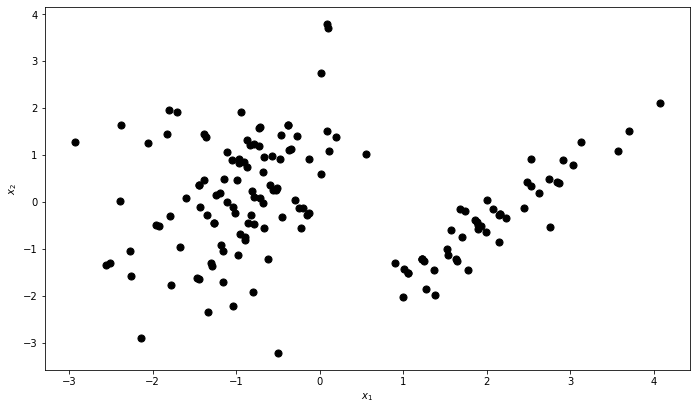

In [15]:
# X - dane ze zbioru "iris" z poprzedniego przykładu

X_pca = pca(X, 2)
fig = plot_unlabeled_data(X_pca)

Analiza głównych składowych umożliwiła stowrzenie powyższego wykresu, który wizualizuje 4-wymiarowe dane ze zbioru *iris* na 2-wymiarowej płaszczyźnie.

Współrzędne $x_1$ i $x_2$, stanowiące osi wykresu, zostały uzyskane w wyniku działania algorytmu PCA (nie są to żadne z oryginalnych cech ze zbioru *iris* – długość płatka, szerokość płatka itp.).